In [1]:
pip install nlpaug

     |████████████████████████████████| 410 kB 8.1 MB/s 


In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import re
from bs4 import BeautifulSoup
from tqdm import tqdm
from nltk.stem import WordNetLemmatizer
import nltk
from nltk.corpus import stopwords
nltk.download('wordnet')
nltk.download('stopwords')
import re
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer
import string

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score, confusion_matrix

import nlpaug.augmenter.char as nac
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.sentence as nas
import nlpaug.flow as nafc

from nlpaug.util import Action

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
data=pd.read_csv("ratings_and_sentiments.csv",encoding= 'unicode_escape')

In [4]:
data.head()

,coffee_shop_name,review_text,rating,num_rating,cat_rating,bool_HIGH,overall_sent,vibe_sent,tea_sent,service_sent,seating_sent,price_sent,parking_sent,location_sent,alcohol_sent,coffee_sent,food_sent,hours_sent,internet_sent,local_sent
0,The Factory - Cafe With a Soul,11/25/2016 1 check-in Love love loved the vib...,5.0 star rating,5.0,HIGH,1.0,4.0,3,0.0,0.0,0.0,0.0,0,0.0,1.0,3,0,0.0,0.0,0.0
1,The Factory - Cafe With a Soul,"12/2/2016 Listed in Date Night: Austin, vibe ...",4.0 star rating,4.0,HIGH,1.0,3.0,3,0.0,0.0,0.0,0.0,0,0.0,0.0,0,2,0.0,0.0,0.0
2,The Factory - Cafe With a Soul,11/30/2016 1 check-in Listed in food seating ...,4.0 star rating,4.0,HIGH,1.0,2.0,2,0.0,0.0,3.0,0.0,0,0.0,0.0,-1,2,0.0,0.0,0.0
3,The Factory - Cafe With a Soul,11/25/2016 Very cool vibe! Good drinks Nice s...,2.0 star rating,2.0,LOW,0.0,1.0,0,0.0,0.0,-1.0,-1.0,0,0.0,0.0,0,0,0.0,0.0,0.0
4,The Factory - Cafe With a Soul,12/3/2016 1 check-in They are location within...,4.0 star rating,4.0,HIGH,1.0,2.0,0,0.0,0.0,0.0,0.0,3,0.0,0.0,0,0,0.0,0.0,0.0


In [5]:
data=data[['review_text','num_rating']]
data.head()

,review_text,num_rating
0,11/25/2016 1 check-in Love love loved the vib...,5.0
1,"12/2/2016 Listed in Date Night: Austin, vibe ...",4.0
2,11/30/2016 1 check-in Listed in food seating ...,4.0
3,11/25/2016 Very cool vibe! Good drinks Nice s...,2.0
4,12/3/2016 1 check-in They are location within...,4.0


In [6]:
data['review_text'].loc[1]

' 12/2/2016 Listed in Date Night: Austin, vibe in Austin BEAUTIFUL!!!! Love the vibe! Instagram-worthy!!!  Definitely $$$, so be prepared. This is gonna cost you a pretty penny :) food food was just decent...nothing to rave about.  But, will probably be back just to be somewhere unique and nice. '

In [7]:
def decontract(text):
    text = re.sub(r"won\'t", "will not", text)
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    return text
lemmatizer = WordNetLemmatizer()


In [8]:
def process_tweet(text):

    stemmer = PorterStemmer()
    stopwords_english = stopwords.words('english')
    # remove stock market tickers like $GE
    text = re.sub(r'\$\w*', '', text)
    # remove old style retweet text "RT"
    text = re.sub(r'^RT[\s]+', '', text)
    # remove hyperlinks
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)
    # remove hashtags
    # only removing the hash # sign from the word
    text = re.sub(r'#', '', text)
    text = str(re.sub("\S*\d\S*", "", text).strip()) 
    text=decontract(text)
    # tokenize texts
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,
                               reduce_len=True)
    tokens = tokenizer.tokenize(text)

    texts_clean = []
    for word in tokens:
        if (word not in stopwords_english and  # remove stopwords
                word not in string.punctuation+'...'):  # remove punctuation
            # 
            stem_word = lemmatizer.lemmatize(word,"v")  # Lemmatizing word
            texts_clean.append(stem_word)

    return " ".join(texts_clean)

In [9]:
process_tweet(data['review_text'].loc[1])

'list date night austin vibe austin beautiful love vibe instagram-worthy definitely prepare gonna cost pretty penny :) food food decent nothing rave probably back somewhere unique nice'

In [10]:
data['review_text']=data['review_text'].apply(lambda x: process_tweet(str(x)))

In [11]:
data=data.loc[(data['num_rating']>3) | (data['num_rating']<3)]
data['num_rating']=data['num_rating'].apply(lambda x: 1 if (x>3)  else 0)
data=data.reset_index()
data=data[['review_text','num_rating']]
data.head()

,review_text,num_rating
0,check-in love love love vibe every corner coff...,1
1,list date night austin vibe austin beautiful l...,1
2,check-in list food seat love eclectic homey pl...,1
3,cool vibe good drink nice seat however everyth...,0
4,check-in location within northcross mall shop ...,1


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6878 entries, 0 to 6877
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   review_text  6878 non-null   object
 1   num_rating   6878 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 107.6+ KB


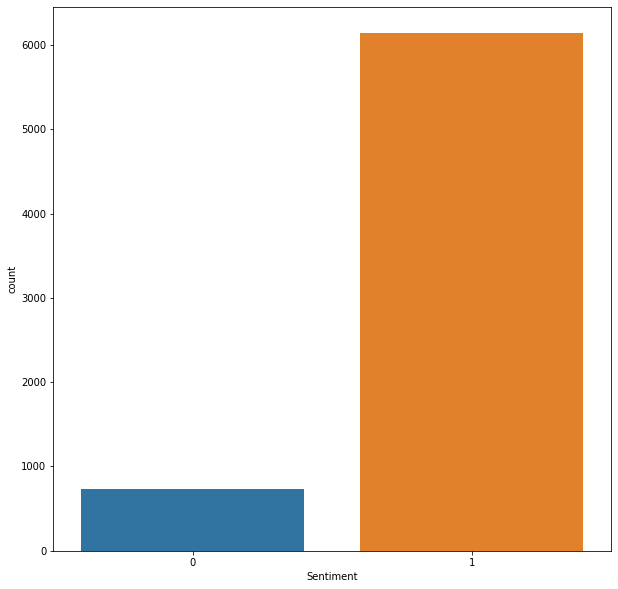

In [13]:
plt.figure(figsize=(10,10))
sns.countplot(data['num_rating']);
plt.xlabel("Sentiment");


In [14]:
X_train, X_test, y_train, y_test = train_test_split(data['review_text'], data['num_rating'], test_size=0.2,random_state=42)


In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2,f_classif, mutual_info_classif


vectorizer = TfidfVectorizer(min_df=3,analyzer='word',max_features=3000)
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized=vectorizer.transform(X_test)

In [16]:
from sklearn.ensemble import RandomForestClassifier

rf=RandomForestClassifier(n_estimators=10)

rf.fit(X_train_vectorized,y_train)




RandomForestClassifier(n_estimators=10)

In [17]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

y_train_pred=rf.predict(X_train_vectorized)


print(confusion_matrix(y_train,y_train_pred))
print(classification_report(y_train,y_train_pred))
print(accuracy_score(y_train, y_train_pred))

[[ 573   14]
 [   1 4914]]
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       587
           1       1.00      1.00      1.00      4915

    accuracy                           1.00      5502
   macro avg       1.00      0.99      0.99      5502
weighted avg       1.00      1.00      1.00      5502

0.9972737186477645


In [18]:
y_pred=rf.predict(X_test_vectorized)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

[[  49  102]
 [   8 1217]]
              precision    recall  f1-score   support

           0       0.86      0.32      0.47       151
           1       0.92      0.99      0.96      1225

    accuracy                           0.92      1376
   macro avg       0.89      0.66      0.71      1376
weighted avg       0.92      0.92      0.90      1376

0.9200581395348837


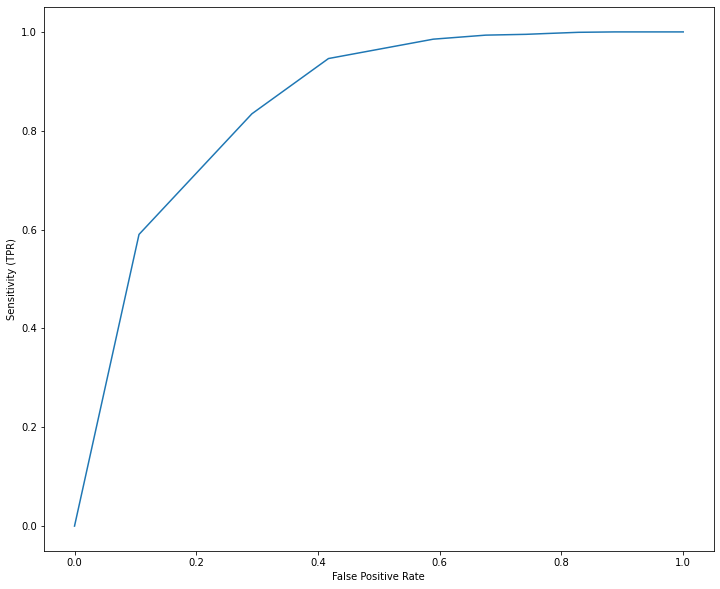

In [19]:
from sklearn.metrics import roc_curve

# roc curve for models
fpr, tpr, thresh = roc_curve(y_test, rf.predict_proba(X_test_vectorized)[:, 1], pos_label=1)
# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)
plt.figure(figsize=(12,10))
sns.lineplot(x=fpr,y=tpr,);

plt.xlabel("False Positive Rate");
plt.ylabel("Sensitivity (TPR)");


In [20]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, rf.predict_proba(X_test_vectorized)[:, 1])

0.8506717123935668

In [21]:
pip install transformers


     |████████████████████████████████| 3.5 MB 8.3 MB/s 
     |████████████████████████████████| 895 kB 33.0 MB/s 
     |████████████████████████████████| 6.8 MB 15.9 MB/s 
     |████████████████████████████████| 67 kB 6.0 MB/s 
     |████████████████████████████████| 596 kB 56.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [22]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [23]:
aug = naw.SynonymAug(aug_src='wordnet',aug_max=3)
#aug = naw.ContextualWordEmbsAug(model_path='bert-base-uncased', action="substitute",aug_max=3,temperature=0.5)

In [24]:
y_train

969     1
6423    1
5771    0
1407    1
3887    1
       ..
3772    1
5191    0
5226    1
5390    0
860     1
Name: num_rating, Length: 5502, dtype: int64

In [25]:
X_train[969]

'check-ins list life like cup coffee minutes kill meet friend nearby food decide check new epoch location things parkinge come coffee shop good ice coffee bitterness topochico clean comfortable place sit epoch take parkinge'

In [26]:
sum(y_train==0)

587

In [27]:
augmented_sentences=[]
augmented_sentences_labels=[]
for i in X_train.index:
  if y_train[i]==0:
    temps=aug.augment(X_train[i],n=2)
    for sent in temps:
      augmented_sentences.append(sent)
      augmented_sentences_labels.append(0)




In [28]:
data=pd.read_csv("ratings_and_sentiments.csv",encoding= 'unicode_escape')

In [29]:
sorted([len(i) for i in data.loc[data['num_rating']==1]['review_text']])
([i for i in data.loc[data['num_rating']==1]['review_text'] if len(i)==90])


[" 7/30/2016 Misleading reviews. Worst coffee I've ever had, and sorely disappointing vibe. "]

In [30]:
naw.SynonymAug(aug_src='wordnet',aug_max=2).augment("Misleading reviews. Worst coffee ever had, and sorely disappointing vibe.",n=2)

['Misleading reviews. Worst coffee ever had, and sorely disappointing vibration.',
 'Misleading reviews. Worst coffee tree ever give birth, and sorely disappointing vibe.']

In [31]:
X_train=X_train.append(pd.Series(augmented_sentences),ignore_index=True)
y_train=y_train.append(pd.Series(augmented_sentences_labels),ignore_index=True)

print(X_train.shape)
print(y_train.shape)

(6676,)
(6676,)


In [32]:
vectorizer = TfidfVectorizer(min_df=3,analyzer='word',max_features=3000)
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized=vectorizer.transform(X_test)
rf=RandomForestClassifier(n_estimators=10)

rf.fit(X_train_vectorized,y_train)


RandomForestClassifier(n_estimators=10)

In [33]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

y_train_pred=rf.predict(X_train_vectorized)


print(confusion_matrix(y_train,y_train_pred))
print(classification_report(y_train,y_train_pred))
print(accuracy_score(y_train, y_train_pred))

[[1761    0]
 [   4 4911]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1761
           1       1.00      1.00      1.00      4915

    accuracy                           1.00      6676
   macro avg       1.00      1.00      1.00      6676
weighted avg       1.00      1.00      1.00      6676

0.9994008388256441


In [34]:
y_pred=rf.predict(X_test_vectorized)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

[[  64   87]
 [  24 1201]]
              precision    recall  f1-score   support

           0       0.73      0.42      0.54       151
           1       0.93      0.98      0.96      1225

    accuracy                           0.92      1376
   macro avg       0.83      0.70      0.75      1376
weighted avg       0.91      0.92      0.91      1376

0.9193313953488372


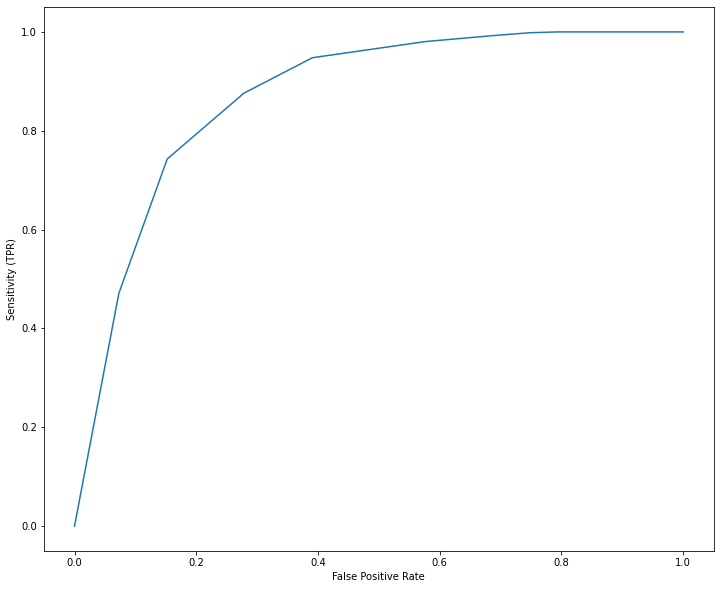

In [35]:
from sklearn.metrics import roc_curve

# roc curve for models
fpr, tpr, thresh = roc_curve(y_test, rf.predict_proba(X_test_vectorized)[:, 1], pos_label=1)
# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)
plt.figure(figsize=(12,10))
sns.lineplot(x=fpr,y=tpr,);

plt.xlabel("False Positive Rate");
plt.ylabel("Sensitivity (TPR)");


In [36]:
roc_auc_score(y_test, rf.predict_proba(X_test_vectorized)[:, 1])

0.8706798215975132